# Introduction

In this notebook we develop a Deep Deterministic Policy Gradients (DDPG) model and analyse its performance on Unity's Reacher environment with one agent.

This part of the second project: *Continuous Control* of **Deep Reinforcement Learning for Enterprise** Course in *Udacity*.

## 0 - Importing Packages

Importing all required packages.

In [1]:
from unityagents import UnityEnvironment
import random
import torch
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from training_ddpg_agent_final import ddpg
from ddpg_agent_final import Agent

## 1 - Initialising Environment

Initialising Unity environment to analyse.

In [2]:
env = UnityEnvironment(file_name='Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## 2 - Untrained Agent

In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment  
action_size = brain.vector_action_space_size  
states = env_info.vector_observations                  # get the current state (for each agent)
num_agents = len(env_info.agents)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


## 3 - Training one DDPG Agent

### 3.1 - Lillicrap's hyperparameters

Defining a dictionary with all hyperparameters inputs in the learning model. Values taken from the experimental details in Lillicrap's article.

In [5]:
dic = {'n_episodes': 500,        # number episodes used for learning
       'max_t': 1000,            # maximum number of steps per episode 
       'actor_fc1_units': 400,   # number of units for first hidden layer actor net
       'actor_fc2_units': 300,   # number of units for second hidden layer actor net
       'critic_fc1_units': 400,  # number of units for first hidden layer critic net
       'critic_fc2_units': 300,  # number of units for second hidden layer critic net
       'buffer_size': int(1e6),  # replay buffer size
       'batch_size': 64,         # minibatch size
       'gamma': 0.99,            # discount factor
       'tau': 1e-3,              # for soft update of target parameters
       'lr_actor': 1e-4,         # learning rate of the actor 
       'lr_critic': 1e-3,        # learning rate of the critic
       'weight_decay': 1e-2,     # L2 weight decay
       'update_every': 1,        # learning step frequency per acting step
       'noise_theta': 0.15,      # Ornstein-Uhlenbeck noise process theta parameter
       'noise_sigma': 0.2,       # Ornstein-Uhlenbeck noise process sigma parameter
       'file': 'chpt_lil'}       # file name to save agent's net weights


Defining two useful functions to transform the scores an times results dictionaries into dataframes.
Initialising dictionaries to collect results.

In [7]:
def maxlen(dic):
    l = 0
    for e in dic.values():
        if len(e) > l:
            l = len(e)
    return l

def dic_fix(dic):
    dicF = {}
    ml = maxlen(dic)
    for i , e in enumerate(dic.values()):
        new = [None] * (ml - len(e))
        dicF[i] = e + new
    return dicF


In [7]:
scores_dic = {}
times_dic = {}

for i in range(5):
    print('Training session:\t' + str(i+1))
    scores, times = ddpg(env, dic)
    scores_dic[i] = scores
    times_dic[i] = times
    
scores_dic_fix = dic_fix(scores_dic)
times_dic_fix = dic_fix(times_dic)
scores_df = pd.DataFrame(scores_dic_fix)
times_df = pd.DataFrame(times_dic_fix)
scores_df.to_csv('scores_lil_analysis.csv')
times_df.to_csv('times_lil_analysis.csv')

Episode 100	Average Score: 0.01	Time Split: 1927.15			 
Episode 200	Average Score: 0.01	Time Split: 1830.74			 
Episode 300	Average Score: 0.01	Time Split: 1901.08			 
Episode 400	Average Score: 0.01	Time Split: 1982.58			 
Episode 500	Average Score: 0.01	Time Split: 2061.97			 
Episode 100	Average Score: 0.56	Time Split: 1328.98			 
Episode 200	Average Score: 0.51	Time Split: 1188.98			 
Episode 300	Average Score: 0.50	Time Split: 1259.18			 
Episode 400	Average Score: 0.46	Time Split: 1344.06			 
Episode 500	Average Score: 0.44	Time Split: 1453.37			 
Episode 100	Average Score: 0.04	Time Split: 1554.90			 
Episode 200	Average Score: 0.04	Time Split: 1363.39			 
Episode 300	Average Score: 0.14	Time Split: 1430.64			 
Episode 400	Average Score: 0.28	Time Split: 1540.88			 
Episode 500	Average Score: 0.31	Time Split: 1681.12			 
Episode 100	Average Score: 0.01	Time Split: 1453.67			 
Episode 200	Average Score: 0.01	Time Split: 1343.00			 
Episode 300	Average Score: 0.06	Time Split: 1435

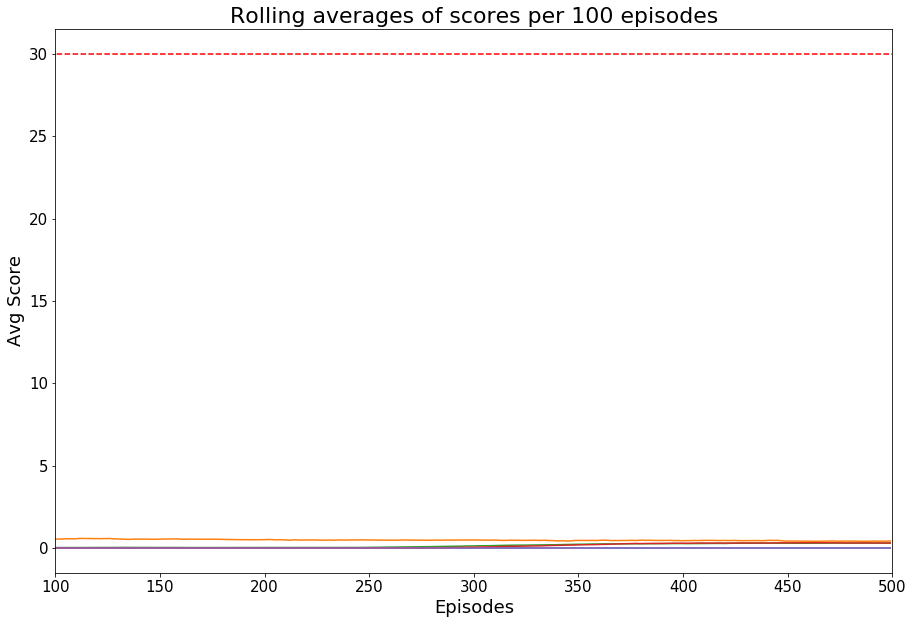

In [5]:
scores_df = pd.read_csv('scores_lil_analysis.csv', index_col=0)
times_df = pd.read_csv('times_lil_analysis.csv', index_col=0)
rolling = scores_df.rolling(100).mean()
ax = rolling.plot(legend=None, xlim=(100,500), figsize=(15, 10), fontsize=15)
ax.set_xlabel("Episodes", fontsize=18)
ax.set_ylabel("Avg Score", fontsize=18)
ax.set_title("Rolling averages of scores per 100 episodes", fontsize=22)
ax.hlines(30, xmin = -2, xmax=600, linestyles='dashed', label='goal', colors='r')
ax.figure.savefig("RollAvgLil.png")

DDPG model using Lillicrap's hyperparameters **failed to solved the environment**. It did not make any significant learning during the 500 episodes training sessions.

### 3.2 - Tuned hyperparameters

Defining a dictionary with all hyperparameters inputs in the learning model. Values tuned to this specific environment.

In [8]:
dic = {'n_episodes': 500,       # number episodes used for learning
       'max_t': 1000,            # maximum number of steps per episode 
       'actor_fc1_units': 400,   # number of units for first hidden layer actor net
       'actor_fc2_units': 300,   # number of units for second hidden layer actor net
       'critic_fc1_units': 400,  # number of units for first hidden layer critic net
       'critic_fc2_units': 300,  # number of units for second hidden layer critic net
       'buffer_size': int(1e5),  # replay buffer size
       'batch_size': 128,        # minibatch size
       'gamma': 0.99,            # discount factor
       'tau': 1e-3,              # for soft update of target parameters
       'lr_actor': 1e-4,         # learning rate of the actor 
       'lr_critic': 1e-4,        # learning rate of the critic
       'weight_decay': 0,        # L2 weight decay
       'update_every': 1,        # learning step frequency per acting step
       'noise_theta': 0.3,       # Ornstein-Uhlenbeck noise process theta parameter
       'noise_sigma': 0.2,       # Ornstein-Uhlenbeck noise process sigma parameter
       'file': 'chpt_tun'}       # file name to save agent's net weights

In [10]:
scores_dic = {}
times_dic = {}

for i in range(5):
    print('Training session:\t' + str(i+1))
    scores, times = ddpg(env, dic)
    scores_dic[i] = scores
    times_dic[i] = times
    
scores_dic_fix = dic_fix(scores_dic)
times_dic_fix = dic_fix(times_dic)
scores_df = pd.DataFrame(scores_dic_fix)
times_df = pd.DataFrame(times_dic_fix)
scores_df.to_csv('scores_tuned_analysis.csv')
times_df.to_csv('times_tuned_analysis.csv')

Training session:	1
Episode 100	Average Score: 2.95	Time Split: 1589.00			 
Episode 200	Average Score: 7.87	Time Split: 1629.97			 
Episode 300	Average Score: 17.39	Time Split: 1608.75			 
Episode 372	Average Score: 30.02	Time Elapsed: 5986.78
Environment solved in 272 episodes!	Average Score: 30.02	Time Elapsed: 5986.78
Training session:	2
Episode 100	Average Score: 2.90	Time Split: 1588.52			 
Episode 200	Average Score: 13.33	Time Split: 1612.16			 
Episode 298	Average Score: 30.07	Time Elapsed: 4785.13
Environment solved in 198 episodes!	Average Score: 30.07	Time Elapsed: 4785.13
Training session:	3
Episode 100	Average Score: 4.22	Time Split: 4160.53			 
Episode 200	Average Score: 18.56	Time Split: 1591.08			 
Episode 248	Average Score: 30.11	Time Elapsed: 6518.65
Environment solved in 148 episodes!	Average Score: 30.11	Time Elapsed: 6518.65
Training session:	4
Episode 100	Average Score: 5.03	Time Split: 1641.49			 
Episode 200	Average Score: 16.30	Time Split: 1663.99			 
Episode 30

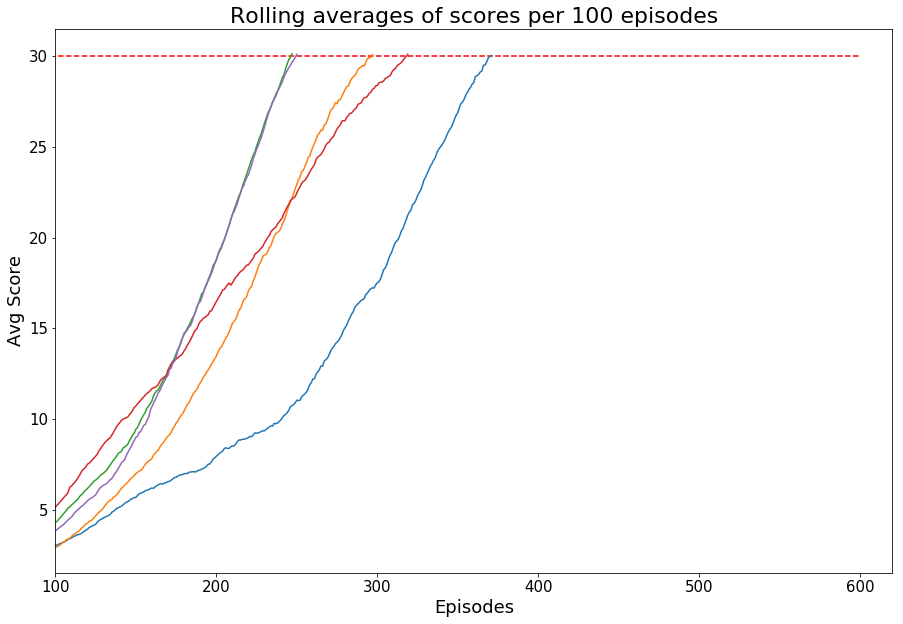

In [12]:
scores_df = pd.read_csv('scores_tuned_analysis.csv', index_col=0)
times_df = pd.read_csv('times_tuned_analysis.csv', index_col=0)
rolling = scores_df.rolling(100).mean()
ax = rolling.plot(legend=None, xlim=(100,620), figsize=(15, 10), fontsize=15)
ax.set_xlabel("Episodes", fontsize=18)
ax.set_ylabel("Avg Score", fontsize=18)
ax.set_title("Rolling averages of scores per 100 episodes", fontsize=22)
ax.hlines(30, xmin = -2, xmax=600, linestyles='dashed', label='goal', colors='r')
ax.figure.savefig("RollAvgTun.png")

In [13]:
total_episodes = scores_df.count() - 100
total_episodes.describe()

count      5.000000
mean     197.800000
std       51.644942
min      148.000000
25%      151.000000
50%      198.000000
75%      220.000000
max      272.000000
dtype: float64

Tuned DDPG model **solves the environment**. It takes on average **200 episodes**. Distribution of results also show relatively high dispersion of **25% standard deviation**.

## 4 - Watch Trained Agents

In [14]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment  
action_size = brain.vector_action_space_size  
state = env_info.vector_observations[0]
state_size = len(state)
num_agents = len(env_info.agents)
score = 0
agent = Agent(state_size=state_size, action_size=action_size)
agent.actor_local.load_state_dict(torch.load('chpt_tun_actor.pth'))

while True:
    action = agent.act(state, add_noise=False)         # select an action  
    env_info = env.step([action])[brain_name]           # send all actions to tne environment
    next_state = env_info.vector_observations[0]       # get next state
    reward = env_info.rewards[0]                       # get reward
    done = env_info.local_done[0]                      # see if episode finished
    score += env_info.rewards[0]                       # update the score 
    state = next_state                                 # roll over states to next time step
    if done:                                           # exit loop if episode finished
        break
print('Total score for this episode: {}'.format(score))

Total score for this episode: 38.72999913431704
